**Stock Forecasting of Activision Blizzard using LSTMs and 1D CNNs**

**Dataset: https://finance.yahoo.com/quote/ATVI/history?p=ATVI**



**Imports**

In [1]:
%pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import time
import seaborn as sns

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
from keras.metrics import *
from keras.losses import *
from keras.constraints import *
from keras.callbacks import *
from keras.optimizers.schedules import *
from keras.regularizers import *

D:\Anaconda\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Import and reindex

In [3]:
to_dt = ['Date']
stocks = pd.read_csv('C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/ATVI.csv',
                    parse_dates = to_dt)

stocks = stocks.set_index('Date')
del stocks['Close']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7225 entries, 1993-10-25 to 2022-07-05
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7225 non-null   float64
 1   High       7225 non-null   float64
 2   Low        7225 non-null   float64
 3   Adj Close  7225 non-null   float64
 4   Volume     7225 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 338.7 KB


Plot each of the different measures

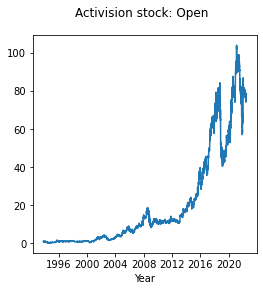

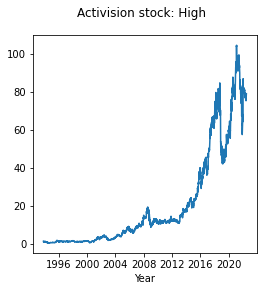

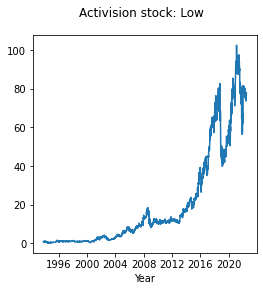

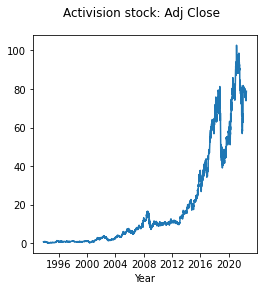

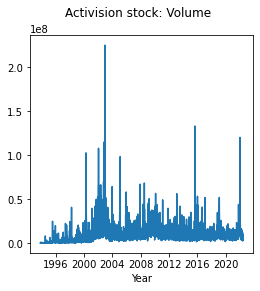

In [4]:
cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

for i in cols:
    plt.figure(figsize = (4,4))
    plt.suptitle(f'Activision stock: {i}')
    plt.xlabel('Year')
    plt.plot(stocks.index, stocks[i], label = i)
plt.show()

Function to reorganize into new shape for time series using a sliding window

In [5]:
def df_to_Xy(df, window_size):
    X = []
    y = []
    
    df = df.to_numpy() # Convert to matrix
    for i in range(len(df) - window_size):
        features_row_window = [row for row in df[i: i + window_size]]
        X.append(features_row_window)
        
        #Target will be adj close (column index 3)
        label = df[i + window_size][3]
        y.append(label)
        
    #convert from list to np arrays
    return np.array(X), np.array(y)

Split stocks into features and labels. Window size of 10

In [6]:
WINDOW_SIZE = 10

X, y = df_to_Xy(stocks, WINDOW_SIZE)

print(X.shape, y.shape)

(7215, 10, 5) (7215,)


Split into training, validation, test sets. 80: 10: 10 split roughly.

In [7]:
pt1 = 7215 // 100
pt80 = pt1 * 80
pt10 = pt1 * 10

print(f'80th: {pt80}')
print(f'90th: {pt80 + pt10}')

X_train, y_train = X[:5760], y[:5760]
X_val, y_val = X[5760: 6480], y[5760: 6480]
X_test, y_test = X[6480:], y[6480:]

print(f'\nTraining set shapes: {X_train.shape, y_train.shape}')
print(f'Validation set shapes: {X_val.shape, y_val.shape}')
print(f'Test set shapes: {X_test.shape, y_test.shape}')

80th: 5760
90th: 6480

Training set shapes: ((5760, 10, 5), (5760,))
Validation set shapes: ((720, 10, 5), (720,))
Test set shapes: ((735, 10, 5), (735,))


Prepare for, and Scale data using MinMaxScaler. Reshape after scaling to fit models.

In [8]:
from sklearn.preprocessing import MinMaxScaler

features_minmaxscaler = MinMaxScaler(feature_range = (0, 1))

#MinMaxScaler requires data to be in 2D format
#Features
Xtr_samples, Xtr_window, Xtr_features = X_train.shape
X_train_2D = np.array(X_train.reshape(Xtr_samples, Xtr_window * Xtr_features))

Xva_samples, Xva_window, Xva_features = X_val.shape
X_val_2D = np.array(X_val.reshape(Xva_samples, Xva_window * Xva_features))

Xte_samples, Xte_window, Xte_features = X_test.shape
X_test_2D = np.array(X_test.reshape(Xte_samples, Xte_window * Xte_features))

X_train_scaled = features_minmaxscaler.fit_transform(X_train_2D)
X_val_scaled = features_minmaxscaler.transform(X_val_2D)
X_test_scaled = features_minmaxscaler.transform(X_test_2D)

#Convert scaled features back into 3D for models.
X_train_scaled = np.array(X_train_scaled.reshape(Xtr_samples, Xtr_window, Xtr_features))
X_val_scaled = np.array(X_val_scaled.reshape(Xva_samples, Xva_window, Xva_features))
X_test_scaled = np.array(X_test_scaled.reshape(Xte_samples, Xte_window, Xte_features))



#Labels - these originally are (no.samples,). Need to be (no.samples, 1) for the scaler.
labels_minmaxscaler = MinMaxScaler(feature_range = (0,1))

y_train_2D = y_train.reshape(-1, 1)
y_val_2D = y_val.reshape(-1, 1)
y_test_2D = y_test.reshape(-1, 1)

y_train_scaled = labels_minmaxscaler.fit_transform(y_train_2D)
y_val_scaled = labels_minmaxscaler.transform(y_val_2D)
y_test_scaled = labels_minmaxscaler.transform(y_test_2D)

#Unscaled versions for plotting
y_train_unscaled = labels_minmaxscaler.inverse_transform(y_train_scaled)
y_val_unscaled = labels_minmaxscaler.inverse_transform(y_val_scaled)
y_test_unscaled = labels_minmaxscaler.inverse_transform(y_test_scaled)

#1D labels
flattened_y_train_scaled = y_train_scaled.flatten()
flattened_y_val_scaled = y_val_scaled.flatten()
flattened_y_test_scaled = y_test_scaled.flatten()

flattened_y_train_unscaled = y_train_unscaled.flatten()
flattened_y_val_unscaled = y_val_unscaled.flatten()
flattened_y_test_unscaled = y_test_unscaled.flatten()

#Check all shapes:
print(f'\nX_train_scaled shape: {X_train_scaled.shape}')
print(f'X_val_scaled shape: {X_val_scaled.shape}')
print(f'X_test_scaled shape: {X_test_scaled.shape}')
print(f'\ny_train_scaled shape: {y_train_scaled.shape}')
print(f'y_val_scaled shape: {y_val_scaled.shape}')
print(f'y_test_scaled shape: {y_test_scaled.shape}')
print(f'\ny_train_unscaled shape: {y_train_unscaled.shape}')
print(f'y_val_unscaled shape: {y_val_unscaled.shape}')
print(f'y_test_unscaled shape: {y_test_unscaled.shape}')


X_train_scaled shape: (5760, 10, 5)
X_val_scaled shape: (720, 10, 5)
X_test_scaled shape: (735, 10, 5)

y_train_scaled shape: (5760, 1)
y_val_scaled shape: (720, 1)
y_test_scaled shape: (735, 1)

y_train_unscaled shape: (5760, 1)
y_val_unscaled shape: (720, 1)
y_test_unscaled shape: (735, 1)


**Functions for reviewing training metrics and predictions**

In [9]:
def plot_training_metrics(history, name):
    history_df = pd.DataFrame(history.history)
    
    x_axis = np.arange(1, len(history_df), 1) # epochs
    
    plt.figure(figsize = (8,8))
    plt.suptitle(f'Training metrics of {name}')
    plt.plot(history_df['loss'], label = 'Training loss')
    plt.plot(history_df['val_loss'], label = 'Validation loss')
    plt.plot(history_df['root_mean_squared_error'], label = 'Training RMSE')
    plt.plot(history_df['val_root_mean_squared_error'], label = 'Validation RMSE')
    
    plt.legend()
    plt.grid(False)
    plt.show()
    
############################################################################################
def plot_unscaled_predictions(model, features, original_labels, name):
    
    predictions = model.predict(features)
    print(f'predictions shape: {predictions.shape}')
    unscaled_predictions = labels_minmaxscaler.inverse_transform(predictions)
    unscaled_predictions_flattened = unscaled_predictions.flatten()
    print(f'flattened_predictions shape: {unscaled_predictions_flattened.shape}')
    
    print(f'original labels shape: {original_labels.shape}')
    unscaled_original_labels = labels_minmaxscaler.inverse_transform(original_labels)
    unscaled_original_labels_flattened = unscaled_original_labels.flatten()
    
    
    unscaled_predictions_df = pd.DataFrame(data = {'Observed_values': unscaled_original_labels_flattened,
                                                  'Predicted_values': unscaled_predictions_flattened,
                                                  'Model_name': name})
    
    print(unscaled_predictions_df)
    plt.figure(figsize = (10,10))
    plt.suptitle(f'Unscaled predictions vs. observations. Model: {name}')
    plt.plot(unscaled_predictions_df['Observed_values'], label = 'Observed', linestyle = 'solid', color = 'blue')
    plt.plot(unscaled_predictions_df['Predicted_values'], label = 'Predicted', linestyle = 'dashed', color = 'orange')
    plt.legend()
    plt.grid(False)
    plt.show()


################################################################################################
#plot all labels and predictions - use y for all_labels

#dataframe with each column as each model
all_unscaled_predictions_df = pd.DataFrame()
global all_unscaled_predictions_df

def plot_all_unscaled(model, name, all_labels, train_X, val_X, test_X):
    
    flattened_observations = all_labels.flatten()
    
    #Train predictions
    train_pred = model.predict(train_X)
    unscaled_train_pred = labels_minmaxscaler.inverse_transform(train_pred)
    flattened_unscaled_train_pred = unscaled_train_pred.flatten()
    
    #Validation predictions
    val_pred = model.predict(val_X)
    unscaled_val_pred = labels_minmaxscaler.inverse_transform(val_pred)
    flattened_unscaled_val_pred = unscaled_val_pred.flatten()
    
    #Testing predictions
    test_pred = model.predict(test_X)
    unscaled_test_pred = labels_minmaxscaler.inverse_transform(test_pred)
    flattened_unscaled_test_pred = unscaled_test_pred.flatten()
    
    all_preds = []
    all_preds = list(flattened_unscaled_train_pred) + list(flattened_unscaled_val_pred) + list(flattened_unscaled_test_pred)
    all_preds_array = np.array(all_preds)
    all_preds_series = pd.Series(all_preds)
    
    all_unscaled_predictions_df.insert(loc = 0, column = f'{name}', value = all_preds_series, allow_duplicates = True)
    
    #Plot a figure with all
    plt.figure(figsize = (14, 8))
    plt.suptitle(f'Model: {name} predictions vs observations')
    plt.plot(flattened_observations, label = 'Observations', linestyle = 'solid', color = 'blue')
    plt.plot(all_preds, label = 'All predictions', linestyle = 'dashed', color = 'orange')
    
    plt.axvline(x = 5760, linestyle = 'dashed', color = 'black', label = 'Validation')
    plt.axvline(x = 6480, linestyle = 'dashed', color = 'black', label = 'Test')
    
    plt.legend()
    plt.grid(False)
    plt.show()
    return all_unscaled_predictions_df
#####################################################################################################


#evaluate model with test results. Add results. Show plot.
evaluation_df = pd.DataFrame(columns = ['loss', 'root_mean_squared_error', 'Model Name'])

def evaluate_model(model, X, y, batch_size, name): 
    global evaluation_df
    evaluation = model.evaluate(X, y, batch_size = batch_size, return_dict = True)
    evaluation['Model Name'] = name
    
    print(evaluation)
    model_evaluation = pd.DataFrame(evaluation, index = [0])
    model_evaluation_row = model_evaluation.iloc[[0]] # selects just row index 0
    
    print('\nevaluation_df below: ')
    evaluation_df = evaluation_df.append(model_evaluation_row, ignore_index = True)
    print(evaluation_df)
    
    plt.figure(figsize = (10,10))
    plt.suptitle(f'All {len(evaluation_df)} models so far evaluation results')
    plt.xlabel('RMSE')
    plt.ylabel('loss')
    sns.scatterplot(data = evaluation_df, x = 'root_mean_squared_error', y = 'loss', hue = 'Model Name')
    plt.show()
    
    
#Plot all unscaled predictions from all models.
def plot_all_models_all_predictions(all_preds_df, fig_x, fig_y, all_labels):
    
    plt.figure(figsize = (fig_x, fig_y))
    plt.suptitle('Unscaled predictions from all models')
    #plt.plot(all_preds_df.index, all_labels, label = 'Actual', color = 'black')
    plt.axvline(x = 5760, linestyle = 'dashed', color = 'black', label = 'Validation')
    plt.axvline(x = 6480, linestyle = 'dashed', color = 'black', label = 'Test')
    
    for column in all_preds_df.columns:
        plt.plot(all_preds_df[column], label = column, linestyle = 'dashed', alpha = 0.75)
    plt.plot(all_preds_df.index, all_labels, label = 'Actual values', color = 'black')
    plt.legend()

**Create some callbacks and learning schedules**

In [10]:
early_stopping_cb = EarlyStopping(monitor = 'val_loss', patience = 15)

reduce_lr_on_plateau_cb = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 0.96)

#Exponential learning schedule after x epochs
def exp_lr(epoch, lr, x):
    while epoch < x:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
exponential_learning_schedule_cb = LearningRateScheduler(exp_lr)
    
#Stepped learning rate
stepped_initial_lr = 0.05
stepped_batches = 32
stepped_decay_steps = len(X_train) // stepped_batches
stepped_decay_rate = 0.95

stepped_ls = ExponentialDecay(initial_learning_rate = stepped_initial_lr,
                              decay_steps = stepped_decay_steps,
                             decay_rate = stepped_decay_rate,
                             staircase = True) 

#Polynomial learning schedules - Square and Cubic
polynomial_initial_lr = 0.01
polynomial_batches = 32
polynomial_decay_steps = len(X_train) // polynomial_batches
polynomial_end_lr = 0.0005
polynomial_power_square = 0.5 # square root 
polynomial_power_cube = 1 / 3 # cube root

squared_polynomial_ls = PolynomialDecay(initial_learning_rate = polynomial_initial_lr,
                                       decay_steps = polynomial_decay_steps,
                                       end_learning_rate = polynomial_end_lr,
                                       power = polynomial_power_square,
                                       cycle = False)

cube_polynomial_ls = PolynomialDecay(initial_learning_rate = polynomial_initial_lr,
                                    decay_steps = polynomial_decay_steps,
                                    end_learning_rate = polynomial_end_lr,
                                    power = polynomial_power_cube,
                                    cycle = False)



**Standard LSTM**

Epoch 1/30
180/180 [==============================] - 4s 24ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.8497 - val_root_mean_squared_error: 0.9218
Epoch 2/30
180/180 [==============================] - 2s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.4867 - val_root_mean_squared_error: 0.6976
Epoch 3/30
180/180 [==============================] - 1s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0675 - val_root_mean_squared_error: 0.2598
Epoch 4/30
180/180 [==============================] - 1s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 5/30
180/180 [==============================] - 1s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0569 - val

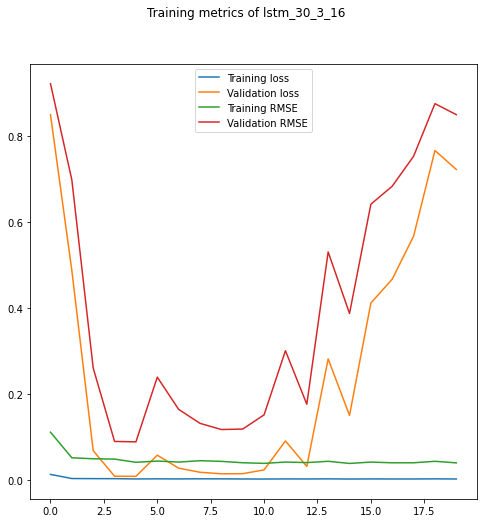

predictions shape: (720, 1)
flattened_predictions shape: (720,)
original labels shape: (720, 1)
     Observed_values  Predicted_values    Model_name
0          42.912151         40.279503  lstm_30_3_16
1          42.767532         40.284527  lstm_30_3_16
2          42.401173         40.351215  lstm_30_3_16
3          42.622917         40.264820  lstm_30_3_16
4          42.574711         40.215214  lstm_30_3_16
..               ...               ...           ...
715        47.618454         41.814644  lstm_30_3_16
716        47.461201         42.057858  lstm_30_3_16
717        47.903477         42.314476  lstm_30_3_16
718        49.328590         42.577408  lstm_30_3_16
719        48.178669         42.915752  lstm_30_3_16

[720 rows x 3 columns]


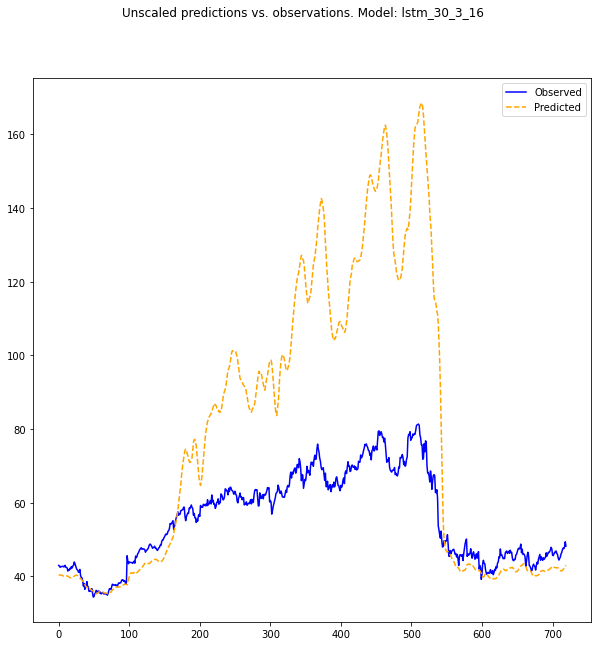

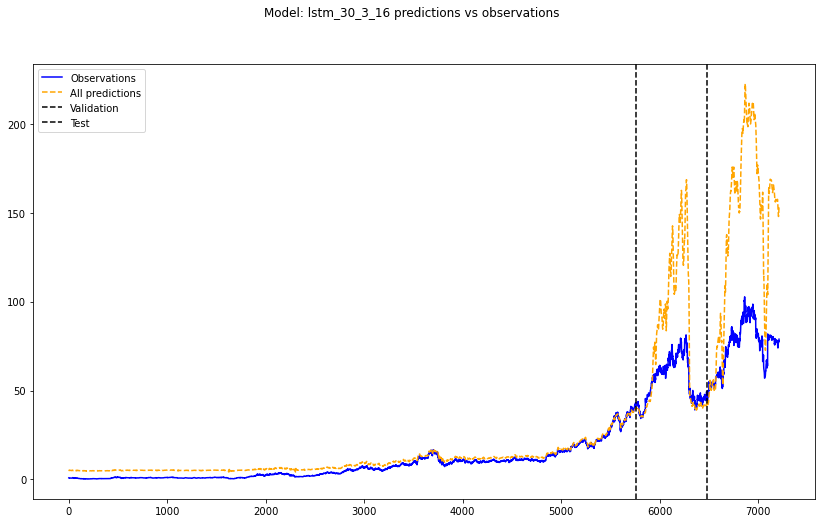

180/180 [==============================] - 1s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708
{'loss': 0.0050177923403680325, 'root_mean_squared_error': 0.0708363801240921, 'Model Name': 'lstm_30_3_16'}

evaluation_df below: 
       loss  root_mean_squared_error    Model Name
0  0.005018                 0.070836  lstm_30_3_16


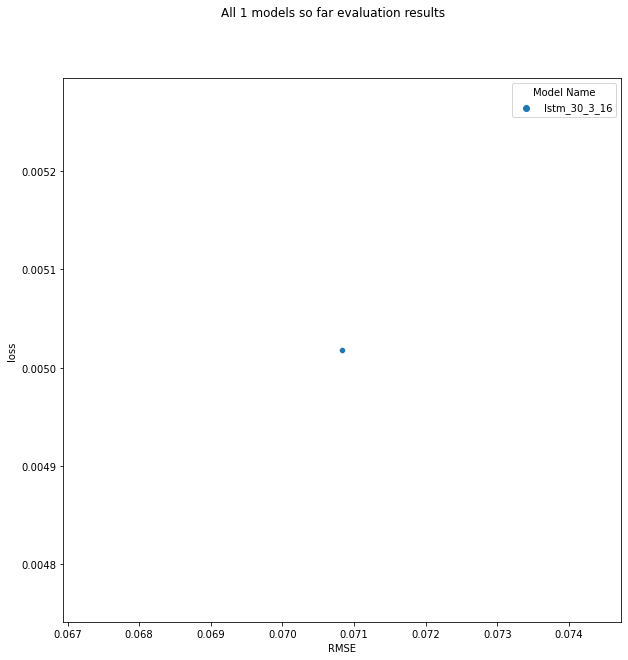

In [11]:
lstm_epochs = 30
lstm_units = 16
lstm_layers = 3
lstm_name = f'lstm_{lstm_epochs}_{lstm_layers}_{lstm_units}'

lstm_checkpoint_cb = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{lstm_name}',
                                       monitor = 'val_loss',
                                       save_freq = 'epoch',
                                       save_weights_only = True)

lstm = Sequential([
    LSTM(units = lstm_units, input_shape = X_train_scaled.shape[1:], kernel_constraint = NonNeg(), return_sequences = True),
    LayerNormalization(),
    LSTM(units = lstm_units, kernel_constraint = NonNeg(), return_sequences = True),
    LayerNormalization(),
    LSTM(units = lstm_units, kernel_constraint = NonNeg(), return_sequences = False),
    Flatten(),
    Dense(16, kernel_initializer = 'he_normal', kernel_constraint = NonNeg()),
    Activation('relu'),
    BatchNormalization(),
    Dense(1, kernel_constraint = NonNeg()),
    Activation('linear')
])

lstm.compile(loss = MeanSquaredError(),
               optimizer = Adam(),
               metrics = [RootMeanSquaredError()])

lstm_history = lstm.fit(X_train_scaled, y_train_scaled,
                             validation_data = (X_val_scaled, y_val_scaled),
                             epochs = lstm_epochs,
                             callbacks = [reduce_lr_on_plateau_cb,
                                         early_stopping_cb,
                                         lstm_checkpoint_cb])

#####
plot_training_metrics(lstm_history, lstm_name) # Model History, Model name
plot_unscaled_predictions(lstm, X_val_scaled, y_val_scaled, lstm_name) # Model, Features, Labels, Model name
plot_all_unscaled(lstm, lstm_name, y, X_train_scaled, X_val_scaled, X_test_scaled) #Model, Model name, All Labels, Train Features, Validation Features, Testing Features
evaluate_model(lstm, X_train_scaled, y_train_scaled, 32, lstm_name) # Model, X, y, Batch size, Model name

**Bidirectional LSTM Model**

Epoch 1/30
180/180 [==============================] - 7s 39ms/step - loss: 0.0303 - root_mean_squared_error: 0.1742 - val_loss: 1.1787 - val_root_mean_squared_error: 1.0857
Epoch 2/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9083
Epoch 3/30
180/180 [==============================] - 2s 10ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.3739 - val_root_mean_squared_error: 0.6115
Epoch 4/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0580 - val_root_mean_squared_error: 0.2408
Epoch 5/30
180/180 [==============================] - 3s 14ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1368
Epoch 6/30
180/180 [==============================] - 2s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0072 

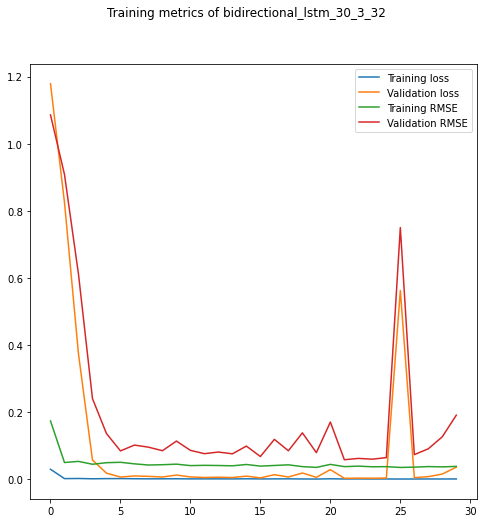

predictions shape: (720, 1)
flattened_predictions shape: (720,)
original labels shape: (720, 1)
     Observed_values  Predicted_values                  Model_name
0          42.912151         37.616707  bidirectional_lstm_30_3_32
1          42.767532         37.740322  bidirectional_lstm_30_3_32
2          42.401173         37.791592  bidirectional_lstm_30_3_32
3          42.622917         37.727955  bidirectional_lstm_30_3_32
4          42.574711         37.671860  bidirectional_lstm_30_3_32
..               ...               ...                         ...
715        47.618454         40.224754  bidirectional_lstm_30_3_32
716        47.461201         40.497429  bidirectional_lstm_30_3_32
717        47.903477         40.726860  bidirectional_lstm_30_3_32
718        49.328590         41.126587  bidirectional_lstm_30_3_32
719        48.178669         41.670681  bidirectional_lstm_30_3_32

[720 rows x 3 columns]


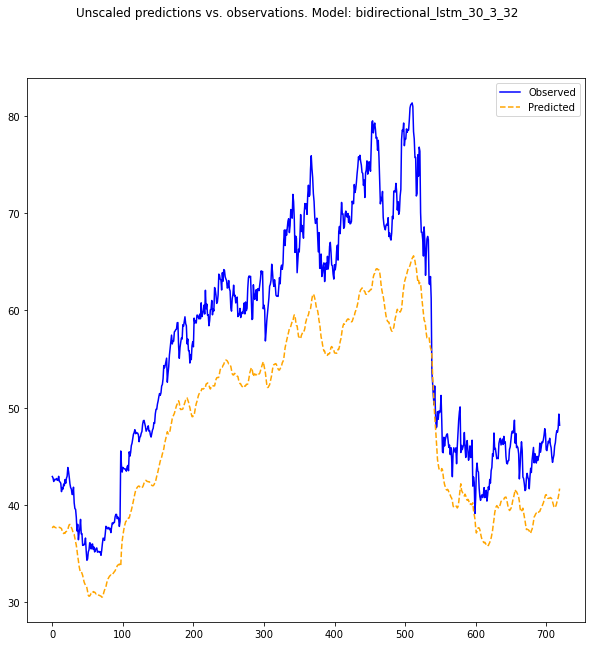

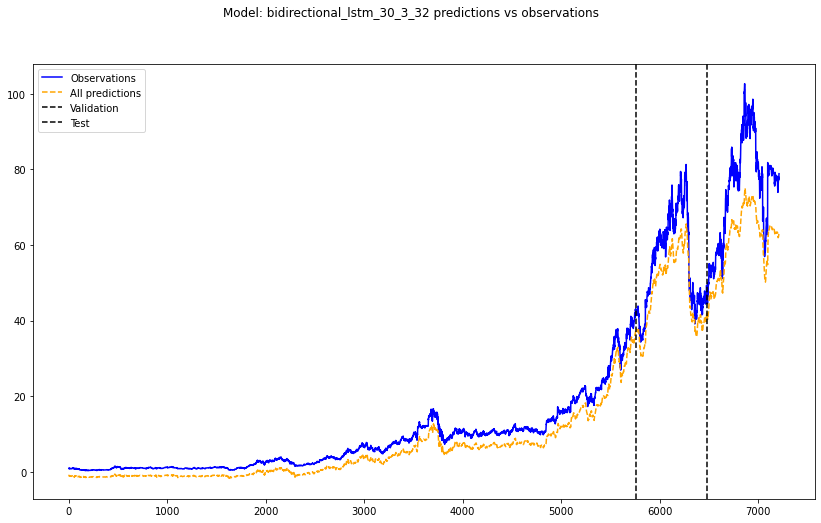

180/180 [==============================] - 1s 5ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
{'loss': 0.00526887271553278, 'root_mean_squared_error': 0.07258699834346771, 'Model Name': 'bidirectional_lstm_30_3_32'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32


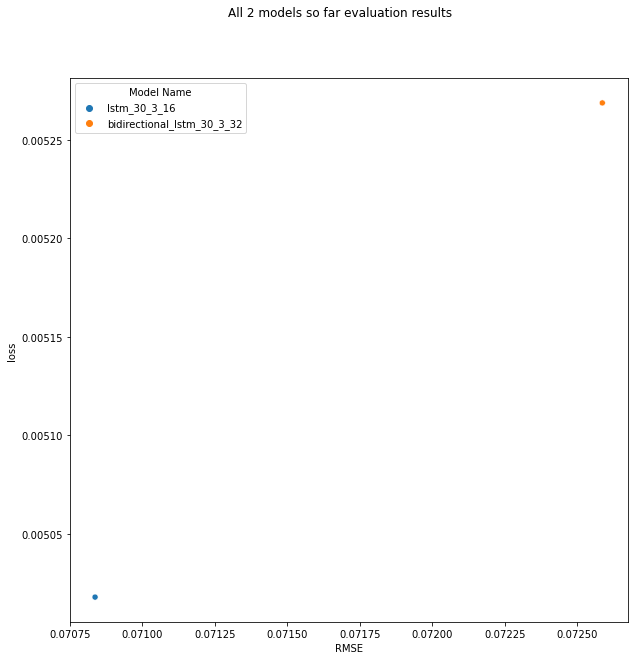

In [12]:
bd_lstm_epochs = 30
bd_lstm_units = 32
bd_lstm_layers = 3
bd_lstm_name = f'bidirectional_lstm_{bd_lstm_epochs}_{bd_lstm_layers}_{bd_lstm_units}'

bd_lstm_checkpoint_cb = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{bd_lstm_name}',
                                       monitor = 'val_loss',
                                       save_freq = 'epoch',
                                       save_weights_only = True)

bd_lstm = Sequential([
    Bidirectional(LSTM(units = bd_lstm_units, input_shape = X_train_scaled.shape[1:], kernel_constraint = NonNeg(), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(LSTM(units = bd_lstm_units, kernel_constraint = NonNeg(), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(LSTM(units = bd_lstm_units, kernel_constraint = NonNeg(), return_sequences = False)),
    Flatten(),
    Dense(16, kernel_initializer = 'he_normal', kernel_constraint = NonNeg()),
    Activation('relu'),
    BatchNormalization(),
    Dense(1, kernel_constraint = NonNeg()),
    Activation('linear')
])

bd_lstm.compile(loss = MeanSquaredError(),
               optimizer = Adam(),
               metrics = [RootMeanSquaredError()])

bd_lstm_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{bd_lstm_name}',
                                    monitor = 'val_loss',
                                    save_weights_only = True,
                                    save_freq = 'epoch',
                                    save_best_only = False)

bd_lstm_history = bd_lstm.fit(X_train_scaled, y_train_scaled,
                             validation_data = (X_val_scaled, y_val_scaled),
                             epochs = bd_lstm_epochs,
                             callbacks = [reduce_lr_on_plateau_cb,
                                         early_stopping_cb,
                                         bd_lstm_checkpoint])

#####
plot_training_metrics(bd_lstm_history, bd_lstm_name)
plot_unscaled_predictions(bd_lstm, X_val_scaled, y_val_scaled, bd_lstm_name)
plot_all_unscaled(bd_lstm, bd_lstm_name, y, X_train_scaled, X_val_scaled, X_test_scaled)
evaluate_model(bd_lstm, X_train_scaled, y_train_scaled, 32, bd_lstm_name)

**1D Convolutional**

Epoch 1/30
180/180 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 2/30
180/180 [==============================] - 0s 2ms/step - loss: 1.8797e-04 - root_mean_squared_error: 0.0137 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 3/30
180/180 [==============================] - 0s 2ms/step - loss: 1.2986e-04 - root_mean_squared_error: 0.0114 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 4/30
180/180 [==============================] - 0s 2ms/step - loss: 1.0786e-04 - root_mean_squared_error: 0.0104 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 5/30
180/180 [==============================] - 0s 2ms/step - loss: 1.2089e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 6/30
180/180 [==============================] - 0s 2ms/step - loss: 1.8014e-04 - root_mean_squared_error: 0.0134 - val

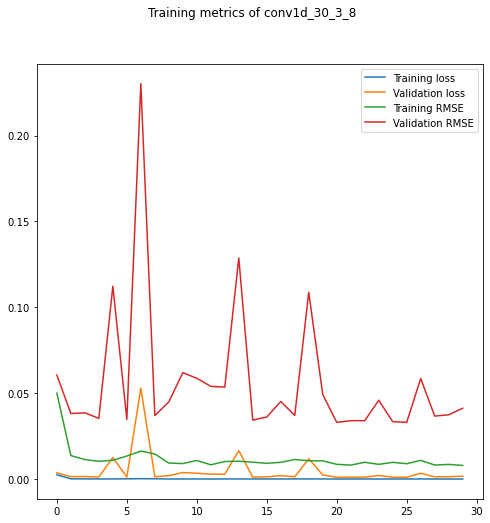

predictions shape: (720, 1)
flattened_predictions shape: (720,)
original labels shape: (720, 1)
     Observed_values  Predicted_values     Model_name
0          42.912151         43.685921  conv1d_30_3_8
1          42.767532         43.873936  conv1d_30_3_8
2          42.401173         43.929359  conv1d_30_3_8
3          42.622917         43.605110  conv1d_30_3_8
4          42.574711         43.388237  conv1d_30_3_8
..               ...               ...            ...
715        47.618454         46.963181  conv1d_30_3_8
716        47.461201         47.408657  conv1d_30_3_8
717        47.903477         47.635723  conv1d_30_3_8
718        49.328590         48.172676  conv1d_30_3_8
719        48.178669         48.981800  conv1d_30_3_8

[720 rows x 3 columns]


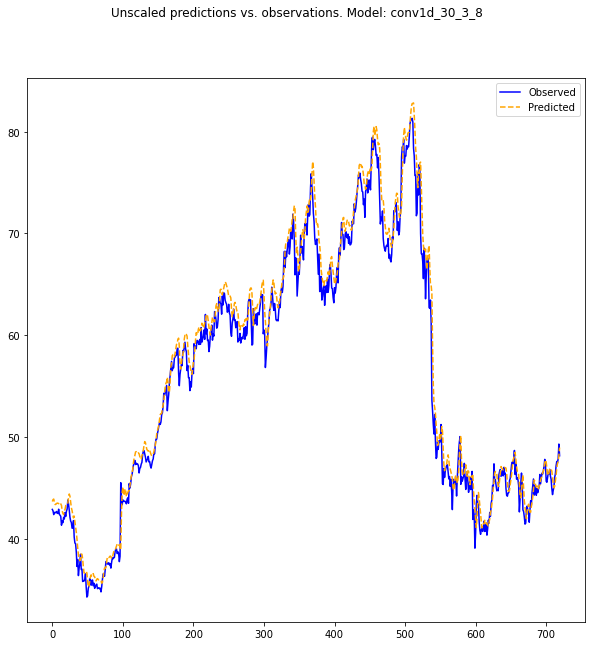

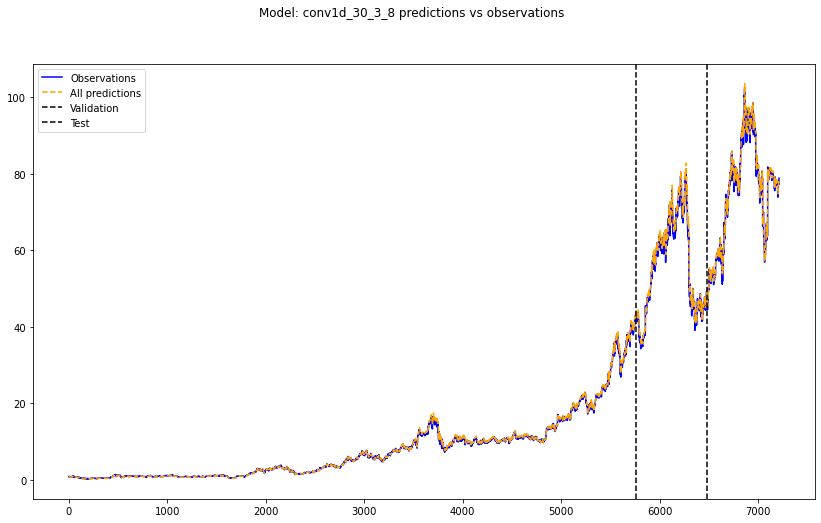

23/23 [==============================] - 0s 870us/step - loss: 0.0019 - root_mean_squared_error: 0.0433
{'loss': 0.0018717623315751553, 'root_mean_squared_error': 0.04326386749744415, 'Model Name': 'conv1d_30_3_8'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8


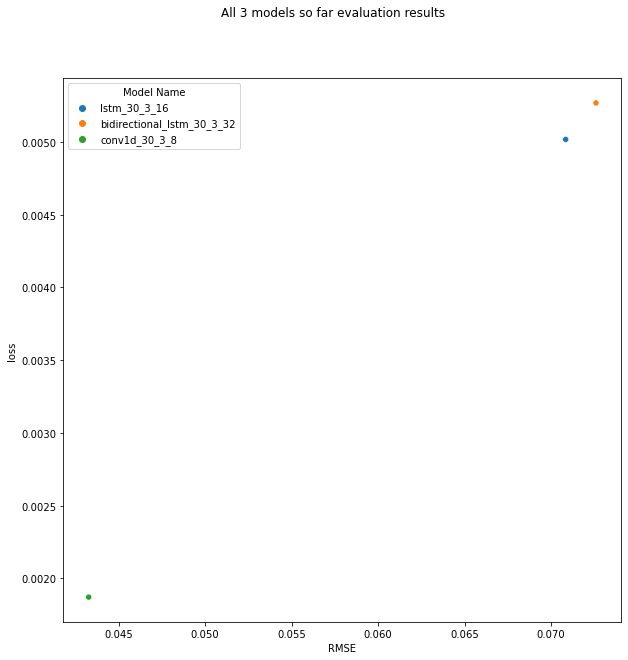

In [13]:
od_conv_epochs = 30
od_conv_filters = 8
od_conv_ksize = 2
od_conv_layers = 3
od_conv_dense_layers = 2

od_conv_name = f'conv1d_{od_conv_epochs}_{od_conv_layers}_{od_conv_filters}'

od_conv_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{od_conv_name}',
                                    monitor = 'val_loss',
                                    save_weights_only = True,
                                    save_best_only = False,
                                    save_freq = 'epoch')

od_conv = Sequential([
    Conv1D(filters = od_conv_filters, input_shape = X_train_scaled.shape[1:], kernel_size = od_conv_ksize, padding = 'same', kernel_constraint = NonNeg()),
    Conv1D(filters = od_conv_filters, kernel_size = od_conv_ksize, padding = 'same', kernel_constraint = NonNeg()),
    Conv1D(filters = od_conv_filters, kernel_size = od_conv_ksize, padding = 'same', kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = 16, kernel_initializer = 'he_normal'),
    Activation('relu'),
    Dense(units = 1),
    Activation('linear')
])

od_conv.compile(loss = MeanSquaredError(),
               optimizer = Adam(),
                metrics = [RootMeanSquaredError()])

od_conv_history = od_conv.fit(X_train_scaled, y_train_scaled,
                             validation_data = (X_val_scaled, y_val_scaled),
                             epochs = od_conv_epochs,
                             callbacks = [reduce_lr_on_plateau_cb,
                                         early_stopping_cb,
                                         od_conv_checkpoint])


plot_training_metrics(od_conv_history, od_conv_name)
plot_unscaled_predictions(od_conv, X_val_scaled, y_val_scaled, od_conv_name) 
plot_all_unscaled(od_conv, od_conv_name, y, X_train_scaled, X_val_scaled, X_test_scaled)
evaluate_model(od_conv, X_test_scaled, y_test_scaled, 32, od_conv_name)

**2D Convolutional**

Epoch 1/30
180/180 [==============================] - 1s 4ms/step - loss: 3.0263 - root_mean_squared_error: 1.6832 - val_loss: 46.8794 - val_root_mean_squared_error: 6.8358
Epoch 2/30
180/180 [==============================] - 0s 2ms/step - loss: 0.5352 - root_mean_squared_error: 0.6429 - val_loss: 3.9916 - val_root_mean_squared_error: 1.9734
Epoch 3/30
180/180 [==============================] - 0s 2ms/step - loss: 0.2097 - root_mean_squared_error: 0.3608 - val_loss: 0.3562 - val_root_mean_squared_error: 0.5404
Epoch 4/30
180/180 [==============================] - 0s 3ms/step - loss: 0.1048 - root_mean_squared_error: 0.2259 - val_loss: 0.0612 - val_root_mean_squared_error: 0.1269
Epoch 5/30
180/180 [==============================] - 0s 2ms/step - loss: 0.0644 - root_mean_squared_error: 0.1589 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2293
Epoch 6/30
180/180 [==============================] - 0s 2ms/step - loss: 0.0426 - root_mean_squared_error: 0.1143 - val_loss: 0.3399 - val

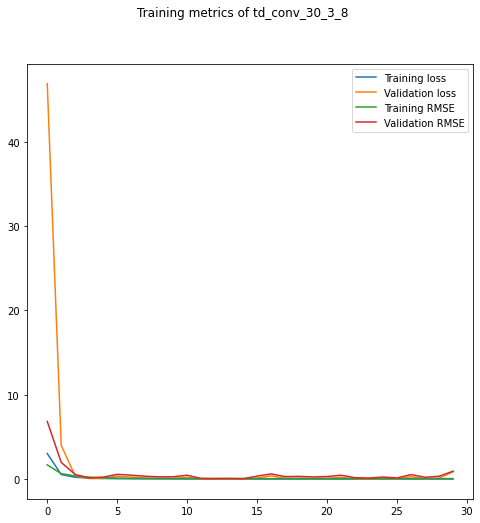

predictions shape: (5760, 1)
flattened_predictions shape: (5760,)
original labels shape: (5760, 1)
      Observed_values  Predicted_values      Model_name
0            0.886573         -4.819938  td_conv_30_3_8
1            0.775752         -4.801574  td_conv_30_3_8
2            0.794222         -4.808074  td_conv_30_3_8
3            0.794222         -4.869403  td_conv_30_3_8
4            0.794222         -4.854755  td_conv_30_3_8
...               ...               ...             ...
5755        42.989277         68.854362  td_conv_30_3_8
5756        42.825378         69.439369  td_conv_30_3_8
5757        42.536148         70.039268  td_conv_30_3_8
5758        42.545795         70.281822  td_conv_30_3_8
5759        43.066406         70.278267  td_conv_30_3_8

[5760 rows x 3 columns]


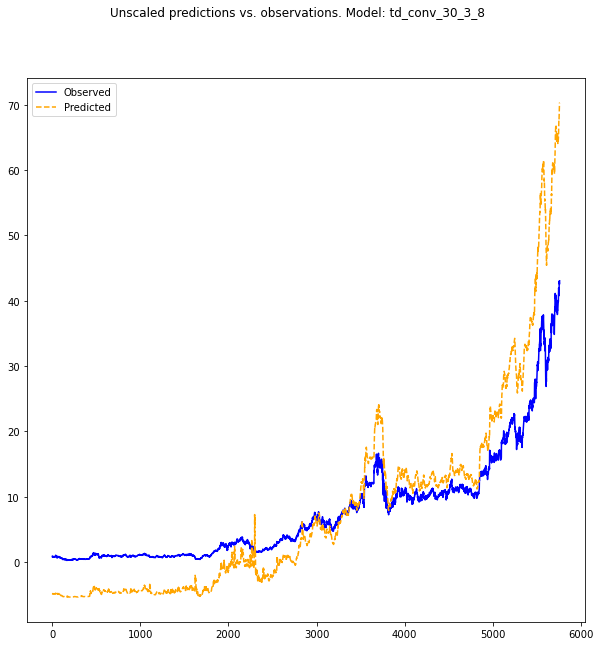

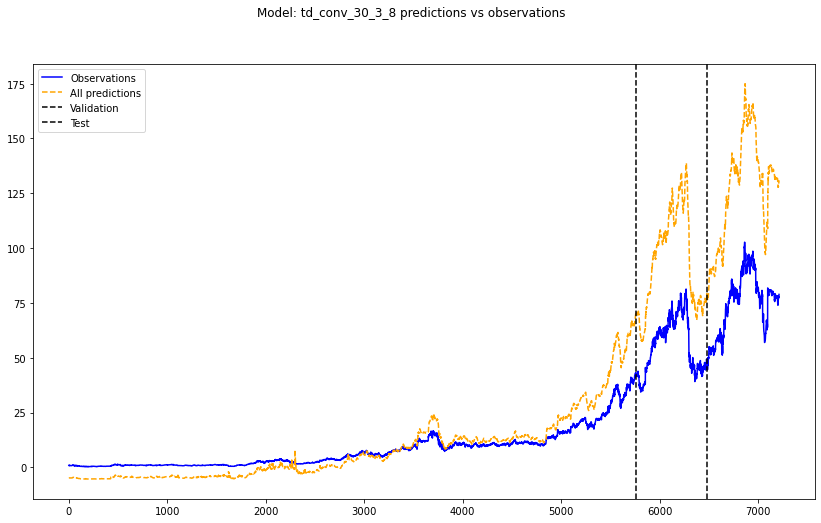

180/180 [==============================] - 0s 1ms/step - loss: 0.0251 - root_mean_squared_error: 0.1565
{'loss': 0.02507002279162407, 'root_mean_squared_error': 0.15645118057727814, 'Model Name': 'td_conv_30_3_8'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8
3  0.025070                 0.156451              td_conv_30_3_8


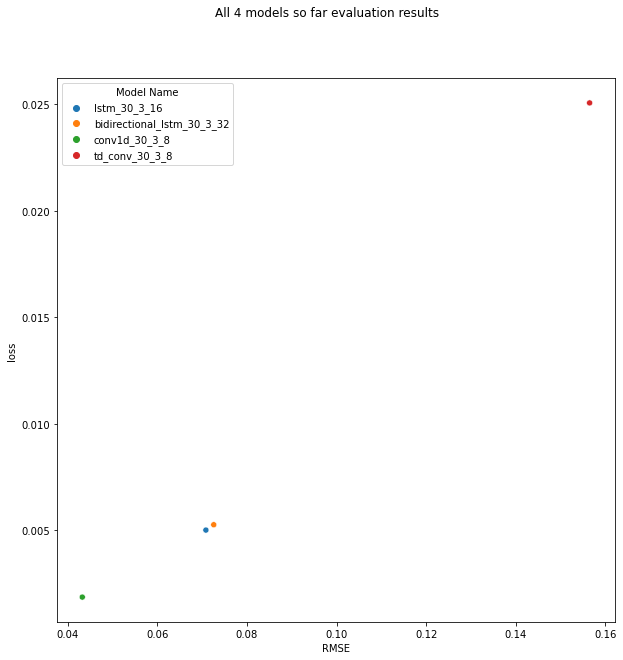

In [14]:
wide_X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], X_train_scaled.shape[2], 1) # 5760, 10, 5, 1
wide_X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], X_val_scaled.shape[2], 1)
wide_X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], X_test_scaled.shape[2], 1)

td_conv_epochs = 30
td_conv_kernel_size = (1, 2)
td_conv_filters = 8
td_conv_layers = 3


td_conv_name = f'td_conv_{td_conv_epochs}_{td_conv_layers}_{td_conv_filters}'

td_conv_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{td_conv_name}',
                                    monitor = 'val_loss',
                                    save_best_only = False,
                                    save_weights_only = True,
                                    save_freq = 'epoch')

td_conv = Sequential([
    Conv2D(input_shape = [wide_X_train_scaled.shape[1], wide_X_train_scaled.shape[2], 1],
          filters = td_conv_filters,
          kernel_size = td_conv_kernel_size,
          padding = 'same',
          kernel_constraint = NonNeg(),
          kernel_initializer = 'he_normal'),
    Activation('relu'),
    Conv2D(filters = td_conv_filters,
          kernel_size = td_conv_kernel_size,
          padding = 'same',
          kernel_constraint = NonNeg(),
          kernel_initializer = 'he_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size = 2,
                padding = 'same'),
    Conv2D(filters = td_conv_filters,
          kernel_size = td_conv_kernel_size,
          padding = 'same',
          kernel_constraint = NonNeg(),
          kernel_initializer = 'he_normal'),
    Activation('relu'),
    
    Flatten(),
    BatchNormalization(),
    Dense(units = 32, kernel_initializer = 'he_normal', kernel_constraint = NonNeg(), kernel_regularizer = keras.regularizers.l1_l2(l1 = 0.001, l2 = 0.001)),
    Activation('relu'),
    BatchNormalization(),
    Dense(units = 1, kernel_constraint = NonNeg()),
    Activation('linear'),
])

td_conv.compile(loss = MeanSquaredError(),
               optimizer = Adam(),
               metrics = [RootMeanSquaredError()])

td_conv_history = td_conv.fit(wide_X_train_scaled, y_train_scaled,
                             validation_data = (wide_X_val_scaled, y_val_scaled),
                             epochs = td_conv_epochs,
                             callbacks = [reduce_lr_on_plateau_cb,
                                          early_stopping_cb,
                                          td_conv_checkpoint])

plot_training_metrics(td_conv_history, td_conv_name)
plot_unscaled_predictions(td_conv, wide_X_train_scaled, y_train_scaled, td_conv_name)
plot_all_unscaled(td_conv, td_conv_name, y, wide_X_train_scaled, wide_X_val_scaled, wide_X_test_scaled) 
evaluate_model(td_conv, wide_X_train_scaled, y_train_scaled, 32, td_conv_name)

**GRU model**

Epoch 1/30
180/180 [==============================] - 3s 17ms/step - loss: 0.0365 - root_mean_squared_error: 0.1909 - val_loss: 0.8509 - val_root_mean_squared_error: 0.9225
Epoch 2/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.9848 - val_root_mean_squared_error: 0.9924
Epoch 3/30
180/180 [==============================] - 2s 12ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.1556 - val_root_mean_squared_error: 0.3944
Epoch 4/30
180/180 [==============================] - 2s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 5/30
180/180 [==============================] - 2s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 6/30
180/180 [==============================] - 2s 11ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.1205 

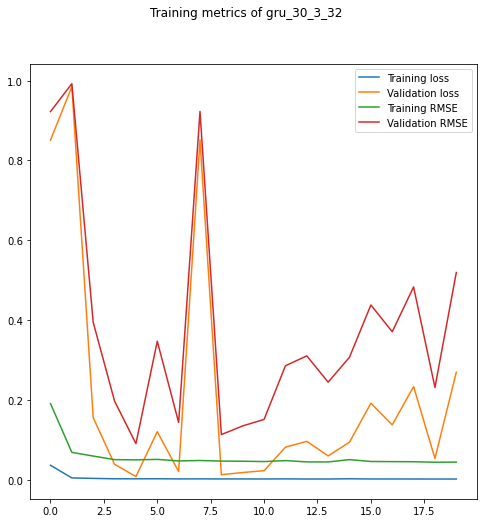

predictions shape: (5760, 1)
flattened_predictions shape: (5760,)
original labels shape: (5760, 1)
      Observed_values  Predicted_values   Model_name
0            0.886573          0.083926  gru_30_3_32
1            0.775752          0.118448  gru_30_3_32
2            0.794222          0.128159  gru_30_3_32
3            0.794222          0.123953  gru_30_3_32
4            0.794222          0.087947  gru_30_3_32
...               ...               ...          ...
5755        42.989277         46.236435  gru_30_3_32
5756        42.825378         46.503376  gru_30_3_32
5757        42.536148         46.922047  gru_30_3_32
5758        42.545795         47.130527  gru_30_3_32
5759        43.066406         47.204952  gru_30_3_32

[5760 rows x 3 columns]


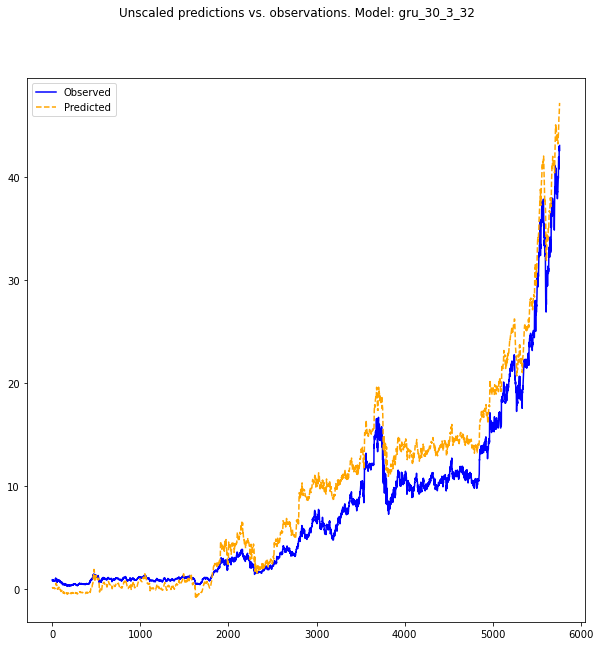

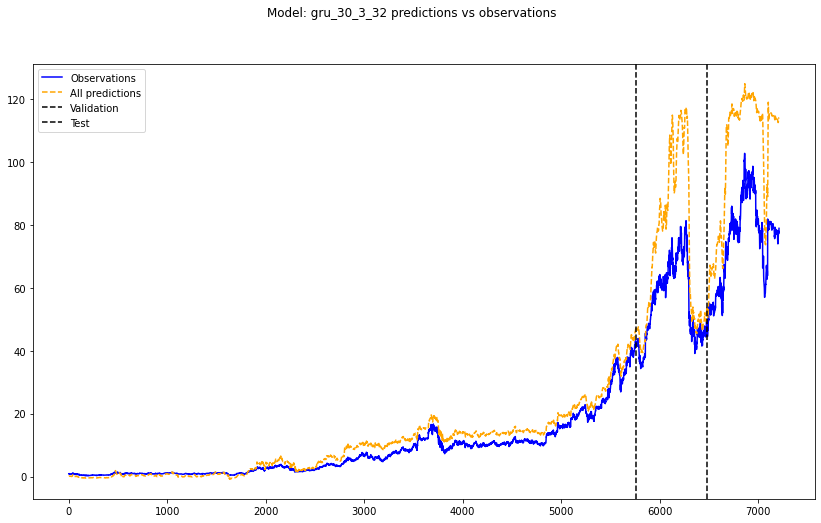

180/180 [==============================] - 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
{'loss': 0.0037579629570245743, 'root_mean_squared_error': 0.06130222603678703, 'Model Name': 'gru_30_3_32'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8
3  0.025070                 0.156451              td_conv_30_3_8
4  0.003758                 0.061302                 gru_30_3_32


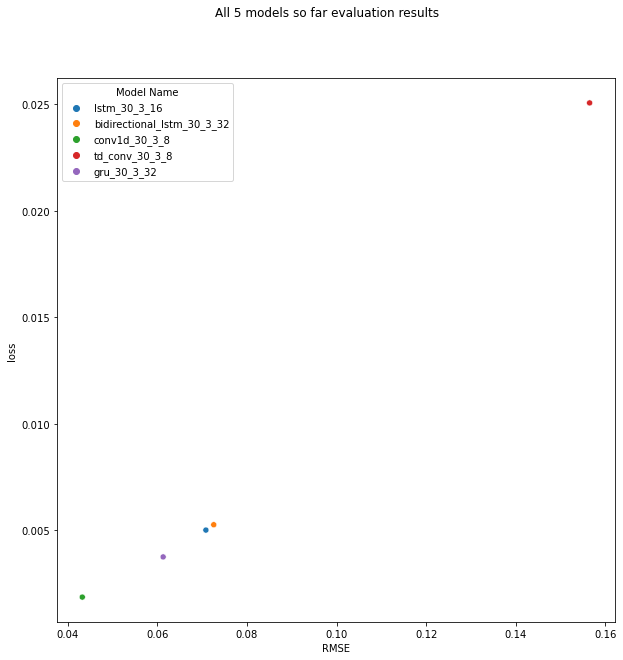

In [15]:
gru_epochs = 30
gru_units = 32
gru_layers = 3


gru_name = f'gru_{gru_epochs}_{gru_layers}_{gru_units}'

gru_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{gru_name}',
                                   save_weights_only = True)

gru = Sequential([
    GRU(units = gru_units, input_shape = X_train_scaled.shape[1:], kernel_constraint = NonNeg(), return_sequences = True),
    LayerNormalization(),
    GRU(units = gru_units, kernel_constraint = NonNeg(), return_sequences = True),
    LayerNormalization(),
    GRU(units = gru_units, kernel_constraint = NonNeg(), return_sequences = False),
    Flatten(),
    
    Dense(units = 32, kernel_initializer = 'he_normal'),
    Activation('relu'),
    BatchNormalization(),
    Dense(units = 1),
    Activation('linear')
])

gru.compile(loss = MeanSquaredError(),
              optimizer = Adam(),
              metrics = [RootMeanSquaredError()])

gru_history = gru.fit(X_train_scaled, y_train_scaled,
                           validation_data = (X_val_scaled, y_val_scaled),
                           epochs = gru_epochs,
                           callbacks = [reduce_lr_on_plateau_cb,
                                       early_stopping_cb,
                                       gru_checkpoint])

plot_training_metrics(gru_history, gru_name) 
plot_unscaled_predictions(gru, X_train_scaled, y_train_scaled, gru_name) 
plot_all_unscaled(gru, gru_name, y, X_train_scaled, X_val_scaled, X_test_scaled) 
evaluate_model(gru, X_train_scaled, y_train_scaled, 32, gru_name) 

**Bidirectional GRU model**

Epoch 1/20
180/180 [==============================] - 3s 19ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - val_loss: 0.9872 - val_root_mean_squared_error: 0.9936
Epoch 2/20
180/180 [==============================] - 2s 10ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.3963 - val_root_mean_squared_error: 0.6295
Epoch 3/20
180/180 [==============================] - 2s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.1777 - val_root_mean_squared_error: 0.4215
Epoch 4/20
180/180 [==============================] - 2s 12ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.1766 - val_root_mean_squared_error: 0.4203
Epoch 5/20
180/180 [==============================] - 2s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.2938 - val_root_mean_squared_error: 0.5420
Epoch 6/20
180/180 [==============================] - 2s 10ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.1723 

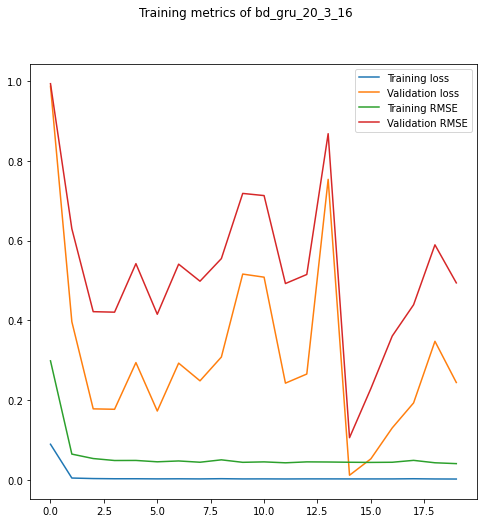

predictions shape: (5760, 1)
flattened_predictions shape: (5760,)
original labels shape: (5760, 1)
      Observed_values  Predicted_values      Model_name
0            0.886573          0.641031  bd_gru_20_3_16
1            0.775752          0.785004  bd_gru_20_3_16
2            0.794222          0.638954  bd_gru_20_3_16
3            0.794222          0.374634  bd_gru_20_3_16
4            0.794222          0.479237  bd_gru_20_3_16
...               ...               ...             ...
5755        42.989277         39.740822  bd_gru_20_3_16
5756        42.825378         40.319736  bd_gru_20_3_16
5757        42.536148         40.859341  bd_gru_20_3_16
5758        42.545795         40.723129  bd_gru_20_3_16
5759        43.066406         40.604691  bd_gru_20_3_16

[5760 rows x 3 columns]


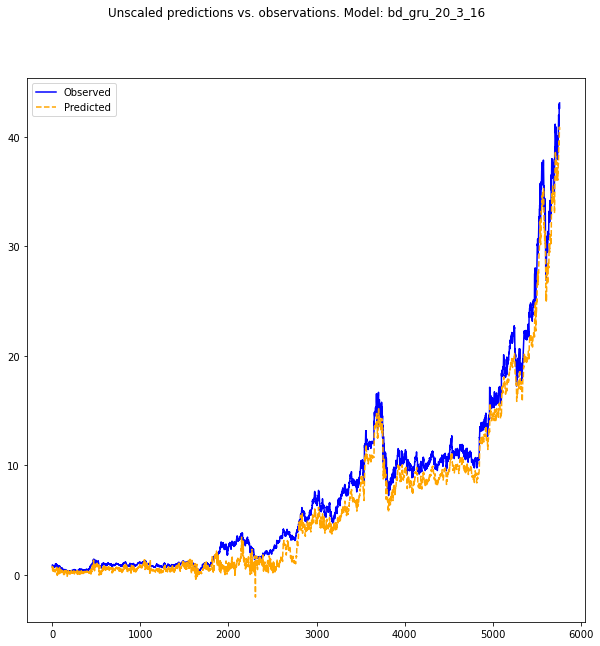

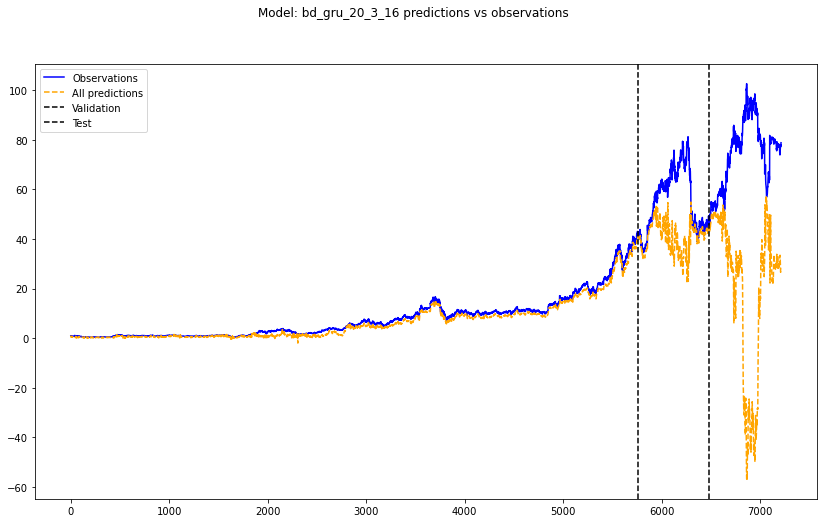

180/180 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331
{'loss': 0.0010976585326716304, 'root_mean_squared_error': 0.03313092887401581, 'Model Name': 'bd_gru_20_3_16'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8
3  0.025070                 0.156451              td_conv_30_3_8
4  0.003758                 0.061302                 gru_30_3_32
5  0.001098                 0.033131              bd_gru_20_3_16


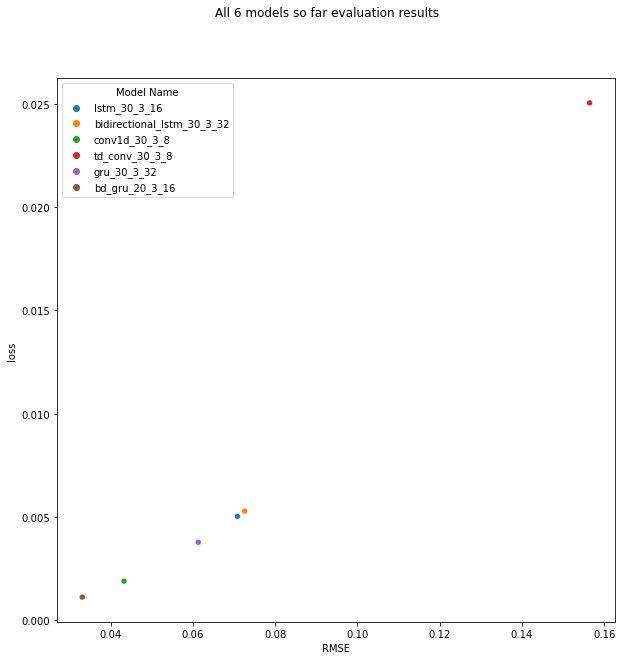

In [16]:
bd_gru_epochs = 20
bd_gru_units = 16
bd_gru_layers = 3


bd_gru_name = f'bd_gru_{bd_gru_epochs}_{bd_gru_layers}_{bd_gru_units}'

bd_gru_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{bd_gru_name}',
                                   save_weights_only = True)
bd_gru_early_stopping_cb = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 10)

bd_gru = Sequential([
    Bidirectional(GRU(units = bd_gru_units, input_shape = X_train_scaled.shape[1:], kernel_constraint = NonNeg(), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(GRU(units = bd_gru_units, kernel_constraint = NonNeg(), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(GRU(units = bd_gru_units, kernel_constraint = NonNeg(), return_sequences = False)),
    Flatten(),
    
    Dense(units = 32, kernel_initializer = 'he_normal'),
    Activation('relu'),
    BatchNormalization(),
    Dense(units = 1),
    Activation('linear')
])

bd_gru.compile(loss = MeanSquaredError(),
              optimizer = Adam(),
              metrics = [RootMeanSquaredError()])

bd_gru_history = bd_gru.fit(X_train_scaled, y_train_scaled,
                           validation_data = (X_val_scaled, y_val_scaled),
                           epochs = bd_gru_epochs,
                           callbacks = [reduce_lr_on_plateau_cb,
                                       bd_gru_early_stopping_cb,
                                       bd_gru_checkpoint])

plot_training_metrics(bd_gru_history, bd_gru_name)
plot_unscaled_predictions(bd_gru, X_train_scaled, y_train_scaled, bd_gru_name) 
plot_all_unscaled(bd_gru, bd_gru_name, y, X_train_scaled, X_val_scaled, X_test_scaled)
evaluate_model(bd_gru, X_train_scaled, y_train_scaled, 32, bd_gru_name)

**Peephole LSTM model**

In [17]:
from tensorflow_addons.rnn import PeepholeLSTMCell

Epoch 1/20
180/180 [==============================] - 3s 18ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 1.2556 - val_root_mean_squared_error: 1.1205
Epoch 2/20
180/180 [==============================] - 2s 12ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.8779 - val_root_mean_squared_error: 0.9370
Epoch 3/20
180/180 [==============================] - 2s 14ms/step - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.3812 - val_root_mean_squared_error: 0.6174
Epoch 4/20
180/180 [==============================] - 3s 15ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0579 - val_root_mean_squared_error: 0.2406
Epoch 5/20
180/180 [==============================] - 3s 14ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 6/20
180/180 [==============================] - 2s 12ms/step - loss: 7.4287e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0

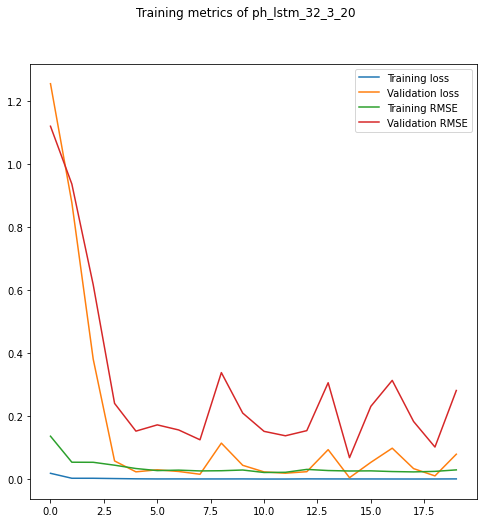

predictions shape: (5760, 1)
flattened_predictions shape: (5760,)
original labels shape: (5760, 1)
      Observed_values  Predicted_values       Model_name
0            0.886573          2.328384  ph_lstm_32_3_20
1            0.775752          2.348386  ph_lstm_32_3_20
2            0.794222          2.321794  ph_lstm_32_3_20
3            0.794222          2.372176  ph_lstm_32_3_20
4            0.794222          2.366160  ph_lstm_32_3_20
...               ...               ...              ...
5755        42.989277         33.424381  ph_lstm_32_3_20
5756        42.825378         33.602325  ph_lstm_32_3_20
5757        42.536148         33.941643  ph_lstm_32_3_20
5758        42.545795         34.181423  ph_lstm_32_3_20
5759        43.066406         34.273403  ph_lstm_32_3_20

[5760 rows x 3 columns]


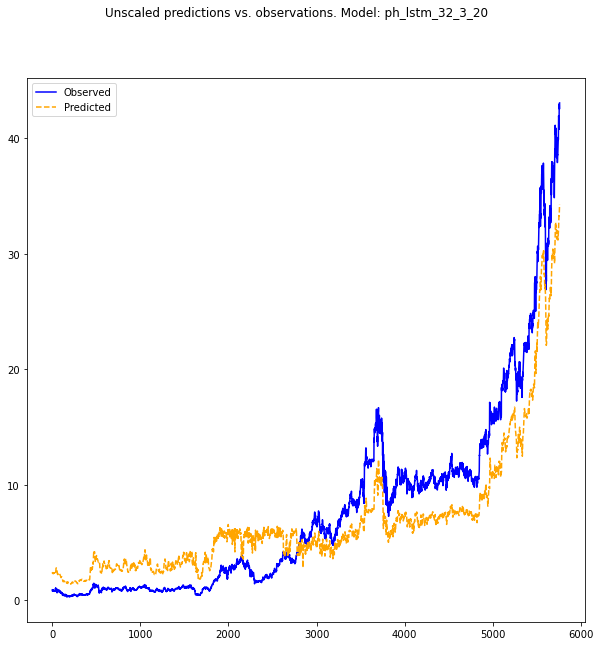

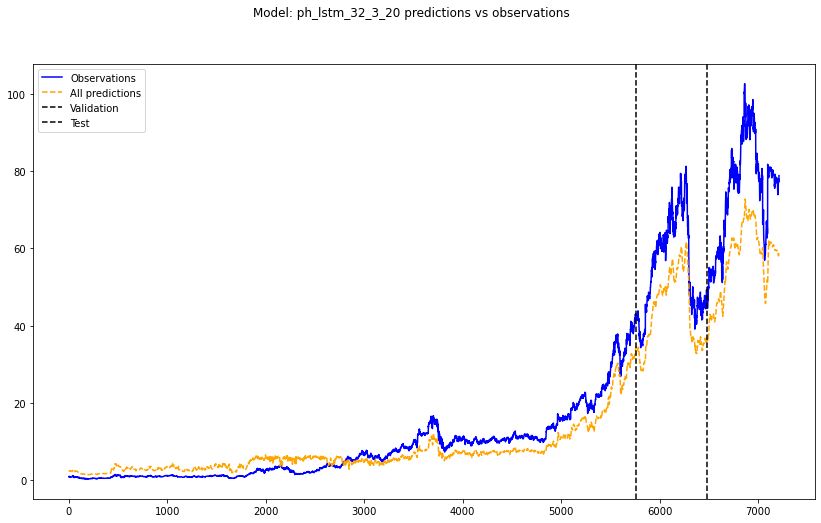

180/180 [==============================] - 1s 4ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792A: 0s - loss: 0.0027 - root_mean_squared_error:
{'loss': 0.006277897395193577, 'root_mean_squared_error': 0.07923318445682526, 'Model Name': 'ph_lstm_32_3_20'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8
3  0.025070                 0.156451              td_conv_30_3_8
4  0.003758                 0.061302                 gru_30_3_32
5  0.001098                 0.033131              bd_gru_20_3_16
6  0.006278                 0.079233             ph_lstm_32_3_20


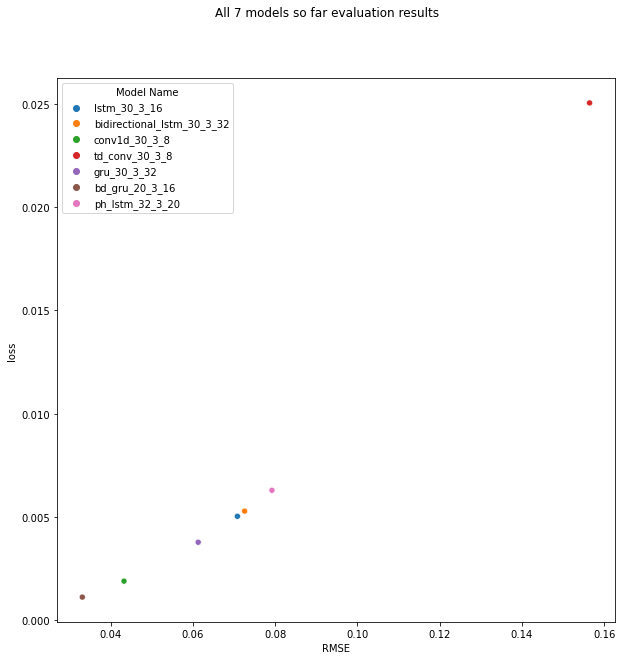

In [18]:
ph_lstm_epochs = 20
ph_lstm_units = 32
ph_lstm_layers = 3


ph_lstm_name = f'ph_lstm_{ph_lstm_units}_{ph_lstm_layers}_{ph_lstm_epochs}'

ph_lstm_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{ph_lstm_name}',
                                    save_weights_only = True)

ph_lstm = Sequential([
    RNN(PeepholeLSTMCell(input_shape = X_train_scaled.shape[1:], units = ph_lstm_units, kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = ph_lstm_units, kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = ph_lstm_units, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    BatchNormalization(),
    Dense(32, kernel_initializer = 'he_normal'),
    Activation('relu'),
    Dense(1),
    Activation('linear')
])

ph_lstm.compile(loss = MeanSquaredError(),
               optimizer = Adam(),
               metrics = [RootMeanSquaredError()])

ph_lstm_history = ph_lstm.fit(X_train_scaled, y_train_scaled,
                             validation_data = (X_val_scaled, y_val_scaled),
                              epochs = ph_lstm_epochs,
                              callbacks = [reduce_lr_on_plateau_cb,
                                          ph_lstm_checkpoint,
                                          early_stopping_cb])


plot_training_metrics(ph_lstm_history, ph_lstm_name)
plot_unscaled_predictions(ph_lstm, X_train_scaled, y_train_scaled, ph_lstm_name)
plot_all_unscaled(ph_lstm, ph_lstm_name, y, X_train_scaled, X_val_scaled, X_test_scaled)
evaluate_model(ph_lstm, X_train_scaled, y_train_scaled, 32, ph_lstm_name)

**Bidirectional Peephole LSTM model**

Epoch 1/20
180/180 [==============================] - 5s 26ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683 - val_loss: 0.3721 - val_root_mean_squared_error: 0.6100
Epoch 2/20
180/180 [==============================] - 3s 16ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.1706 - val_root_mean_squared_error: 0.4130
Epoch 3/20
180/180 [==============================] - 3s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.1541 - val_root_mean_squared_error: 0.3925
Epoch 4/20
180/180 [==============================] - 2s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.1911 - val_root_mean_squared_error: 0.4371
Epoch 5/20
180/180 [==============================] - 3s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.1191 - val_root_mean_squared_error: 0.3450
Epoch 6/20
180/180 [==============================] - 3s 15ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.1398 

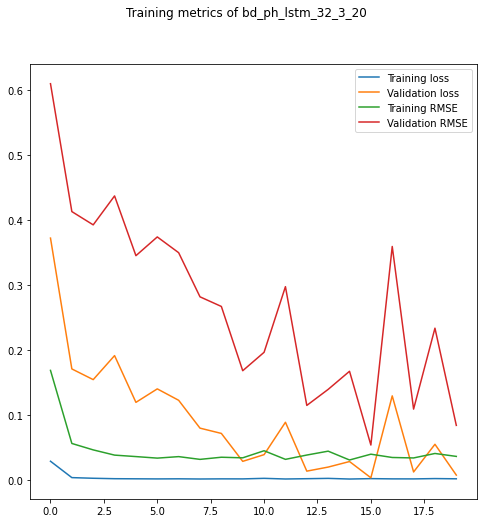

predictions shape: (5760, 1)
flattened_predictions shape: (5760,)
original labels shape: (5760, 1)
      Observed_values  Predicted_values          Model_name
0            0.886573          2.422705  bd_ph_lstm_32_3_20
1            0.775752          2.431768  bd_ph_lstm_32_3_20
2            0.794222          2.318416  bd_ph_lstm_32_3_20
3            0.794222          2.383815  bd_ph_lstm_32_3_20
4            0.794222          2.338076  bd_ph_lstm_32_3_20
...               ...               ...                 ...
5755        42.989277         44.471951  bd_ph_lstm_32_3_20
5756        42.825378         44.813698  bd_ph_lstm_32_3_20
5757        42.536148         45.288063  bd_ph_lstm_32_3_20
5758        42.545795         45.408520  bd_ph_lstm_32_3_20
5759        43.066406         45.369286  bd_ph_lstm_32_3_20

[5760 rows x 3 columns]


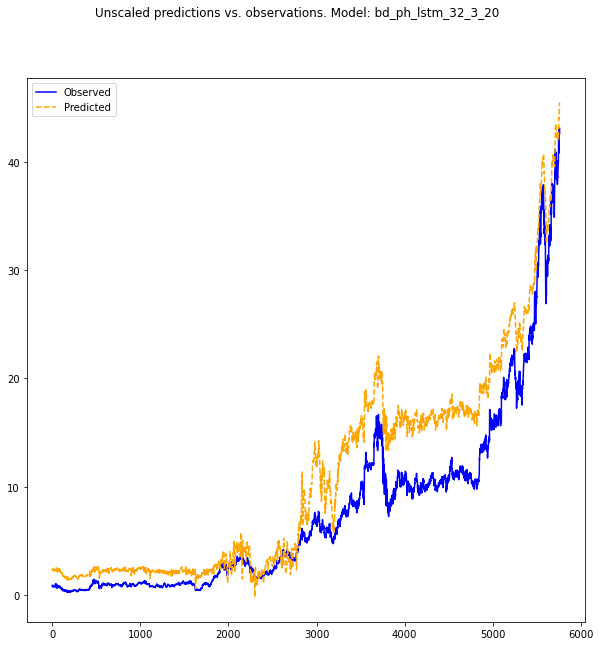

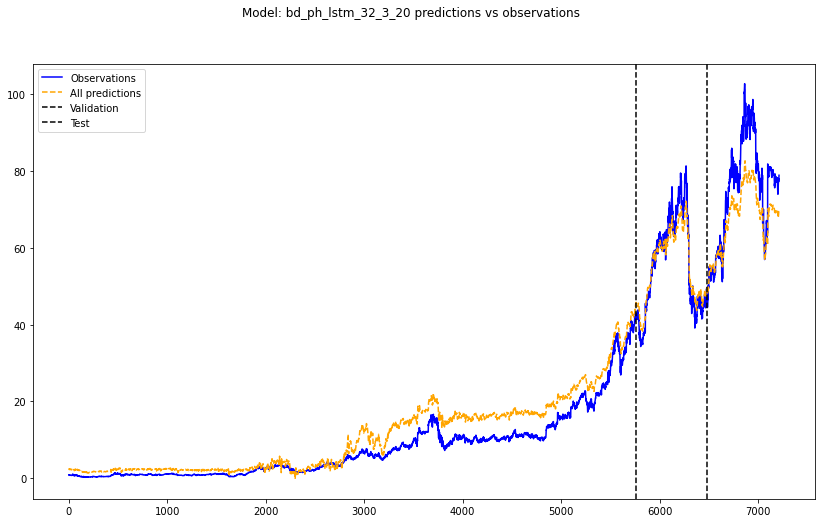

180/180 [==============================] - 1s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898
{'loss': 0.008066093549132347, 'root_mean_squared_error': 0.08981143683195114, 'Model Name': 'bd_ph_lstm_32_3_20'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8
3  0.025070                 0.156451              td_conv_30_3_8
4  0.003758                 0.061302                 gru_30_3_32
5  0.001098                 0.033131              bd_gru_20_3_16
6  0.006278                 0.079233             ph_lstm_32_3_20
7  0.008066                 0.089811          bd_ph_lstm_32_3_20


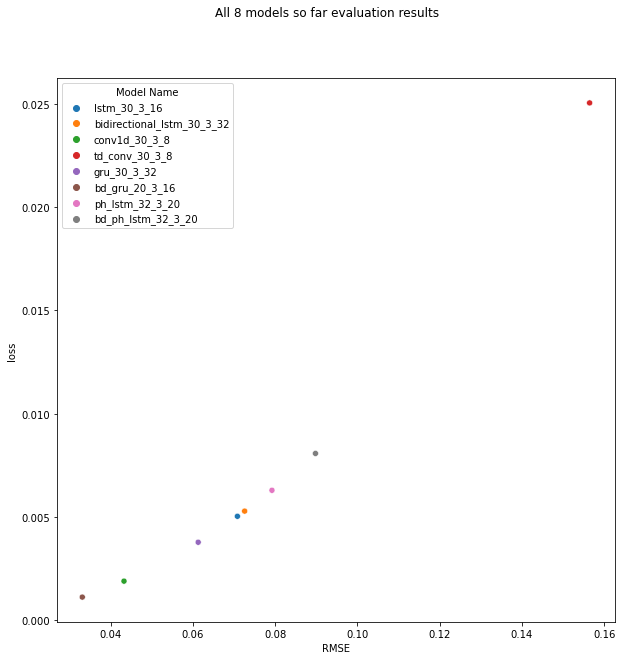

In [19]:
bd_ph_lstm_epochs = 20
bd_ph_lstm_units = 32
bd_ph_lstm_layers = 3


bd_ph_lstm_name = f'bd_ph_lstm_{bd_ph_lstm_units}_{bd_ph_lstm_layers}_{bd_ph_lstm_epochs}'

bd_ph_lstm_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{bd_ph_lstm_name}',
                                       save_weights_only = True)

bd_ph_lstm = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(input_shape = X_train_scaled.shape[1:], units = bd_ph_lstm_units, kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = bd_ph_lstm_units, kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = bd_ph_lstm_units, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    BatchNormalization(),
    Dense(32, kernel_initializer = 'he_normal'),
    Activation('relu'),
    Dense(1),
    Activation('linear')
])

bd_ph_lstm.compile(loss = MeanSquaredError(),
               optimizer = Adam(),
               metrics = [RootMeanSquaredError()])

bd_ph_lstm_history = bd_ph_lstm.fit(X_train_scaled, y_train_scaled,
                             validation_data = (X_val_scaled, y_val_scaled),
                              epochs = bd_ph_lstm_epochs,
                              callbacks = [reduce_lr_on_plateau_cb,
                                          early_stopping_cb,
                                          bd_ph_lstm_checkpoint])


plot_training_metrics(bd_ph_lstm_history, bd_ph_lstm_name) 
plot_unscaled_predictions(bd_ph_lstm, X_train_scaled, y_train_scaled, bd_ph_lstm_name) 
plot_all_unscaled(bd_ph_lstm, bd_ph_lstm_name, y, X_train_scaled, X_val_scaled, X_test_scaled) 
evaluate_model(bd_ph_lstm, X_train_scaled, y_train_scaled, 32, bd_ph_lstm_name)

**NASCell model**

In [20]:
from tensorflow_addons.rnn import NASCell

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
180/180 [==============================] - 3s 17ms/step - loss: 0.3228 - root_mean_squared_error: 0.5682 - val_loss: 0.6000 - val_root_mean_squared_error: 0.7746
Epoch 2/30
180/180 [==============================] - 2s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.6955 - val_root_mean_squared_error: 0.8340
Epoch 3/30
180/180 [==============================] - 

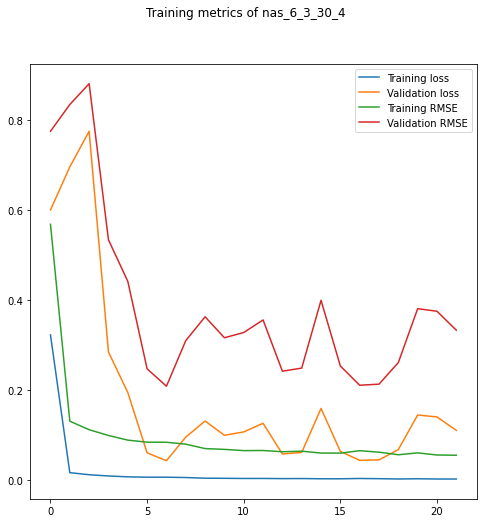

predictions shape: (5760, 1)
flattened_predictions shape: (5760,)
original labels shape: (5760, 1)
      Observed_values  Predicted_values    Model_name
0            0.886573          5.488307  nas_6_3_30_4
1            0.775752          5.603417  nas_6_3_30_4
2            0.794222          5.657839  nas_6_3_30_4
3            0.794222          5.779065  nas_6_3_30_4
4            0.794222          5.723820  nas_6_3_30_4
...               ...               ...           ...
5755        42.989277         38.766342  nas_6_3_30_4
5756        42.825378         38.930340  nas_6_3_30_4
5757        42.536148         39.217709  nas_6_3_30_4
5758        42.545795         39.255234  nas_6_3_30_4
5759        43.066406         39.655582  nas_6_3_30_4

[5760 rows x 3 columns]


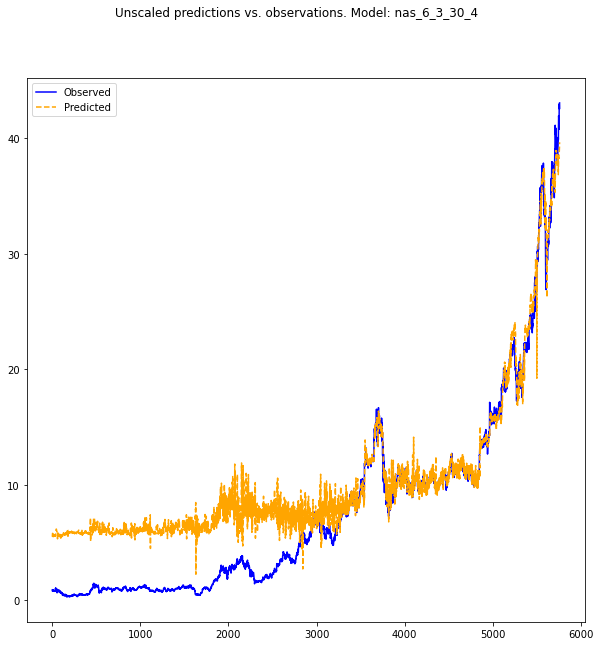

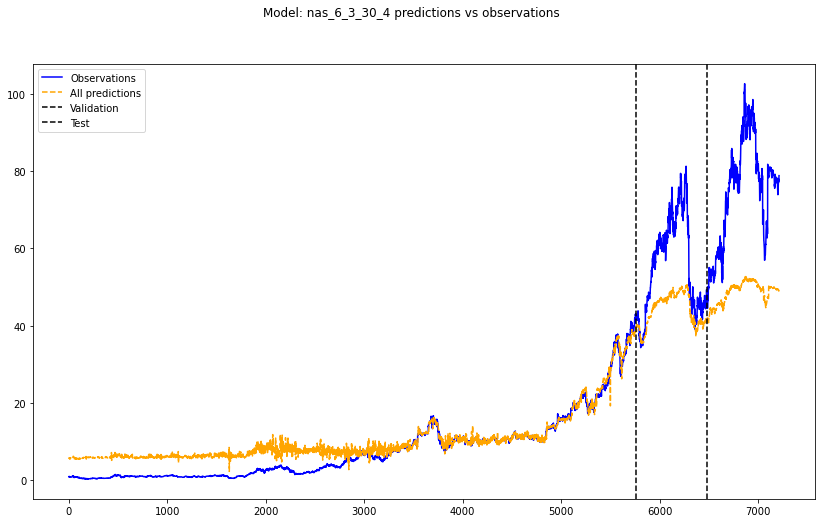

180/180 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878
{'loss': 0.00770046329125762, 'root_mean_squared_error': 0.08775228261947632, 'Model Name': 'nas_6_3_30_4'}

evaluation_df below: 
       loss  root_mean_squared_error                  Model Name
0  0.005018                 0.070836                lstm_30_3_16
1  0.005269                 0.072587  bidirectional_lstm_30_3_32
2  0.001872                 0.043264               conv1d_30_3_8
3  0.025070                 0.156451              td_conv_30_3_8
4  0.003758                 0.061302                 gru_30_3_32
5  0.001098                 0.033131              bd_gru_20_3_16
6  0.006278                 0.079233             ph_lstm_32_3_20
7  0.008066                 0.089811          bd_ph_lstm_32_3_20
8  0.007700                 0.087752                nas_6_3_30_4


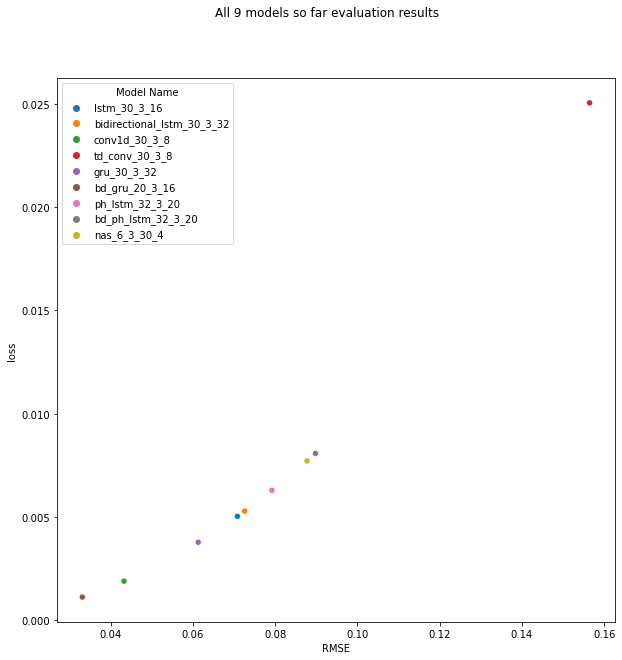

In [21]:
nas_epochs = 30
nas_units = 6
nas_layers = 3
nas_projection_dim = 4

nas_name = f'nas_{nas_units}_{nas_layers}_{nas_epochs}_{nas_projection_dim}'

nas_checkpoint = ModelCheckpoint(filepath = f'C:/Users/tomwr/Desktop/data_science_projects/RNN work/ROBLOX_STOCKS/checkpoints/{nas_name}',
                                save_weights_only = True)

nas = Sequential([
    RNN(NASCell(units = nas_units, input_shape = X_train_scaled.shape[1:], projection = nas_projection_dim), return_sequences = True),
    LayerNormalization(),
    RNN(NASCell(units = nas_units, projection = nas_projection_dim), return_sequences = True),
    LayerNormalization(),
    RNN(NASCell(units = nas_units, projection = nas_projection_dim), return_sequences = True),
    LayerNormalization(),
    Flatten(),
    BatchNormalization(),
    Dense(units = 32, kernel_initializer = 'he_normal', kernel_constraint = NonNeg()),
    Activation('relu'),
    BatchNormalization(),
    Dense(units = 1, kernel_constraint = NonNeg()),
    Activation('linear')
])

nas.compile(loss = MeanSquaredError(),
           optimizer = Adam(),
           metrics = [RootMeanSquaredError()])

nas_history = nas.fit(X_train_scaled, y_train_scaled,
                     validation_data = (X_val_scaled, y_val_scaled),
                     epochs = nas_epochs,
                     callbacks = [reduce_lr_on_plateau_cb,
                                 early_stopping_cb,
                                 nas_checkpoint])

plot_training_metrics(nas_history, nas_name)
plot_unscaled_predictions(nas, X_train_scaled, y_train_scaled, nas_name) 
plot_all_unscaled(nas, nas_name, y, X_train_scaled, X_val_scaled, X_test_scaled)
evaluate_model(nas, X_train_scaled, y_train_scaled, 32, nas_name)

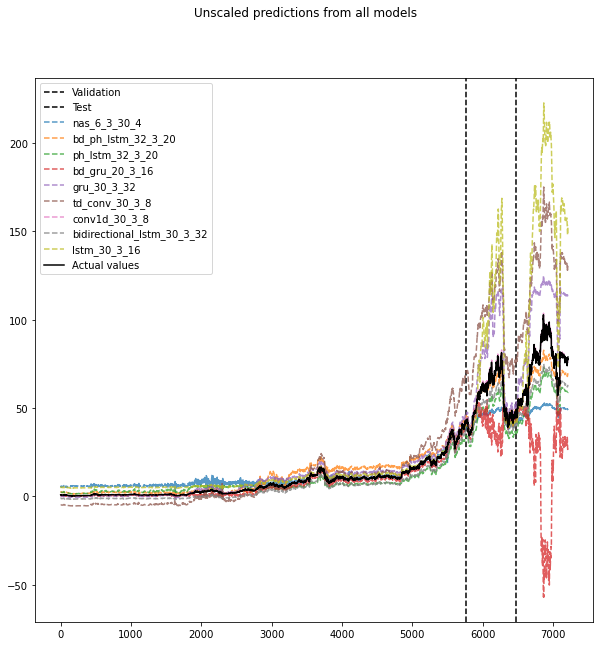

In [22]:
plot_all_models_all_predictions(all_unscaled_predictions_df, 10, 10, y)

In [45]:
best_evaluation_loss = min(evaluation_df['loss'])
best_evaluation_model_df = evaluation_df.loc[evaluation_df['loss'] == best_evaluation_loss]
best_evaluation_model_name = str(best_evaluation_model_df['Model Name'].values)
best_evaluation_model_loss = str(best_evaluation_model_df['loss'].values)

print(f'\nBest perfoming model is {best_evaluation_model_name} with an evaluation loss of {best_evaluation_model_loss}')


Best perfoming model is ['bd_gru_20_3_16'] with an evaluation loss of [0.00109766]
